Main Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB
None

Extra Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10384 entries, 0 to 10383
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   InstanceID   10384 non-null  int64 
 1   patientID    10384 non-null  int64 
 2   ImageName    10384 non-null  object
 3   isCancerous  10384 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 324.6+ KB
None

Main Data Sample:
   InstanceID  patientI

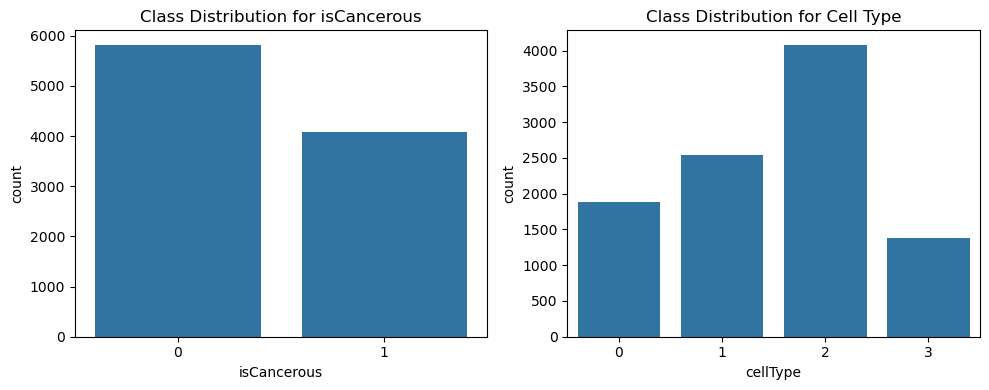


--- Checking for Missing Values ---
InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

--- Summary Statistics for Main Data ---
         InstanceID    patientID     cellType  isCancerous
count   9896.000000  9896.000000  9896.000000  9896.000000
mean   10193.880154    29.762025     1.501516     0.412187
std     6652.912660    17.486553     0.954867     0.492253
min        1.000000     1.000000     0.000000     0.000000
25%     4135.750000    14.000000     1.000000     0.000000
50%     9279.500000    26.000000     2.000000     0.000000
75%    16821.250000    47.000000     2.000000     1.000000
max    22444.000000    60.000000     3.000000     1.000000
Displaying sample images from the dataset:


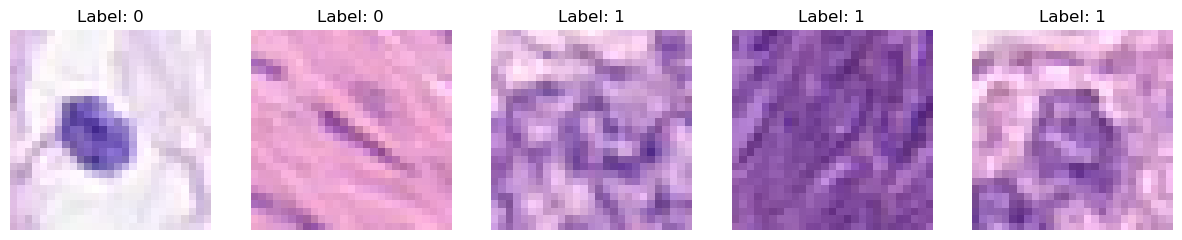

isCancerous
0    0.587813
1    0.412187
Name: proportion, dtype: float64
cellType
2    0.412187
1    0.256973
0    0.190784
3    0.140057
Name: proportion, dtype: float64


In [1]:
""# Colon Cancer Image Classification Project
# Step 1: Data Loading and Exploration

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

# Paths to CSV files and Image folder
MAIN_DATA_CSV = 'data_labels_mainData.csv'
EXTRA_DATA_CSV = 'data_labels_extraData.csv'
IMAGE_FOLDER = 'patch_images/'

# Load CSV data
main_data = pd.read_csv(MAIN_DATA_CSV)
extra_data = pd.read_csv(EXTRA_DATA_CSV)

# Display basic info
print('Main Data Information:')
print(main_data.info())
print('\nExtra Data Information:')
print(extra_data.info())

# Display first few rows
print('\nMain Data Sample:')
print(main_data.head())
print('\nExtra Data Sample:')
print(extra_data.head())

# Check class distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.countplot(x='isCancerous', data=main_data)
plt.title('Class Distribution for isCancerous')
plt.subplot(1, 2, 2)
sns.countplot(x='cellType', data=main_data)
plt.title('Class Distribution for Cell Type')
plt.tight_layout()
plt.show()

# Function to load and display a few images
def display_sample_images(df, image_folder, num_samples=5):
    samples = df.sample(num_samples)
    plt.figure(figsize=(15, 3))
    for idx, row in enumerate(samples.iterrows()):
        img_path = os.path.join(image_folder, row[1]['ImageName'])
        img = Image.open(img_path)
        plt.subplot(1, num_samples, idx + 1)
        plt.imshow(img)
        plt.title(f"Label: {row[1]['isCancerous']}")
        plt.axis('off')
    plt.show()

# Checking for Missing Values
print("\n--- Checking for Missing Values ---")
print(main_data.isnull().sum())

# Summary Statistics for Main Data
print("\n--- Summary Statistics for Main Data ---")
print(main_data.describe())


# Display some sample images
print("Displaying sample images from the dataset:")
display_sample_images(main_data, IMAGE_FOLDER)
# Checking class balance
print(main_data['isCancerous'].value_counts(normalize=True))
print(main_data['cellType'].value_counts(normalize=True))



There is an imbalance between non cancerous (58.78 %) in comparison to cancerous (41.22%), meaning the modelk may be bias towards non cancerous. 

This means careful metric selection and data balancing is needed to ensure cancerous cases aren't overlooked

The cellType shows a clear imbalance across its four categories. Type 2 is the most prevalent (41.22%), while Type 3 is the least represented (14.01%). This imbalance could bias the model to perform better on Type 2 cells while misclassifying less represented types, such as Type 3. To mitigate this, class balancing strategies such as augmentation or class-weight adjustments will be considered during model training.

additionally from the sample images, blur looks like a potential issue

In [2]:
from sklearn.model_selection import train_test_split

patient_ids = main_data['patientID'].unique()


train_x, temp_x = train_test_split(patient_ids, test_size=0.3, random_state=42)


val_x, test_x = train_test_split(temp_x, test_size=0.5, random_state=42)

train_Data = main_data[main_data['patientID'].isin(train_x)]
val_Data = main_data[main_data['patientID'].isin(val_x)]
test_Data = main_data[main_data['patientID'].isin(test_x)]

print(f"Train: {len(train_Data)}, Val: {len(val_Data)}, Test: {len(test_Data)}")

train_patients_set = set(train_x)
val_patients_set = set(val_x)
test_patients_set = set(test_x)

overlap_train_val = train_patients_set.intersection(val_patients_set)
overlap_train_test = train_patients_set.intersection(test_patients_set)
overlap_val_test = val_patients_set.intersection(test_patients_set)

print(f"Train-Val Overlap: {overlap_train_val}")
print(f"Train-Test Overlap: {overlap_train_test}")
print(f"Val-Test Overlap: {overlap_val_test}")


Train: 6778, Val: 1257, Test: 1861
Train-Val Overlap: set()
Train-Test Overlap: set()
Val-Test Overlap: set()


6778 + 1257 + 1861 = 9896, which matches with amount of patients count from earlier. Meaning there should be no overlap but I did additionally make a method to ensure there is no overlap

F1-score will be used as the primary evaluation metric because it balances precision and recall, making it more suitable for imbalanced datasets where accuracy can be misleading.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

train_Data.loc[:, 'isCancerous_str'] = train_Data['isCancerous'].astype(str)
val_Data.loc[:, 'isCancerous_str'] = val_Data['isCancerous'].astype(str)
test_Data.loc[:, 'isCancerous_str'] = test_Data['isCancerous'].astype(str)

train_Datagen = ImageDataGenerator(
    rescale=1./255
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_Datagen.flow_from_dataframe(
    train_Data,
    directory=IMAGE_FOLDER,
    x_col='ImageName',
    y_col='isCancerous_str',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_Data,
    directory=IMAGE_FOLDER,
    x_col='ImageName',
    y_col='isCancerous_str',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_Data,
    directory=IMAGE_FOLDER,
    x_col='ImageName',
    y_col='isCancerous_str',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)
#checking to see if tensor detects my gpu 
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from tensorflow.keras import layers, models
#since this is binary, lamda iun't needed yet
def create_cnn_model():
    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def create_mlp_model():
    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

cnn_model = create_cnn_model()
cnn_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


mlp_model = create_mlp_model()
mlp_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history_cnn = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop]
)

history_mlp = mlp_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop]
)

def plot_learning_curves(history, model_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend()
    plt.show()

plot_learning_curves(history_cnn, 'CNN')

plot_learning_curves(history_mlp, 'MLP')

from sklearn.metrics import f1_score, classification_report

test_preds_cnn = cnn_model.predict(test_generator)
test_preds_cnn_labels = (test_preds_cnn > 0.5).astype(int)

test_preds_mlp = mlp_model.predict(test_generator)
test_preds_mlp_labels = (test_preds_mlp > 0.5).astype(int)

true_labels = test_generator.classes

f1_cnn = f1_score(true_labels, test_preds_cnn_labels)
f1_mlp = f1_score(true_labels, test_preds_mlp_labels)

print(f'CNN Test F1-Score: {f1_cnn:.4f}')
print(f'MLP Test F1-Score: {f1_mlp:.4f}')


C:\Users\kumar\AppData\Local\Temp\ipykernel_7724\1945924595.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_Data.loc[:, 'isCancerous_str'] = train_Data['isCancerous'].astype(str)
C:\Users\kumar\AppData\Local\Temp\ipykernel_7724\1945924595.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_Data.loc[:, 'isCancerous_str'] = val_Data['isCancerous'].astype(str)
C:\Users\kumar\AppData\Local\Temp\ipykernel_7724\1945924595.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Found 6778 validated image filenames belonging to 2 classes.
Found 1257 validated image filenames belonging to 2 classes.
Found 1861 validated image filenames belonging to 2 classes.
Num GPUs Available:  0
